In [2]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LinearRegression

In [3]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [4]:
lat_keys = np.arange(0,22,1)
lat_values = latitudes
lon_keys = np.arange(0,144,1)
lon_values = longitudes

In [5]:
lat_dic = dict(zip(lat_values, lat_keys))
lon_dic = dict(zip(lon_values, lon_keys))

# Qsat Code Section

In [6]:
def magnus_esat_ice(temperature):
    temperature = temperature - 273.15
    esat = 611.21*np.exp((22.587*temperature)/(temperature+273.86))

    return esat
    
def magnus_esat_water(temperature):
    temperature = temperature - 273.15
    esat = 610.94*np.exp((17.265*temperature)/(temperature+243.04))
    return esat

def MAGNUS(T):
    R = 287
    Rv = 461
    esat_water = magnus_esat_water(T)
    esat_ice = esat = magnus_esat_ice(T)
    esat_water[T < 273.15] = 0
    esat_ice[T >= 273.15] = 0
    esat = esat_ice+esat_water 
    return esat

In [7]:
def e_sat_general(temperature):
    temperature - 273.15
    esat_water = esat = (np.exp(34.494-(4924.99/(temperature+273.1))))/(temperature+105)**1.37
    esat_ice = (np.exp(43.494-(6545.8/(temperature+278.0))))/(temperature+868.0)**2
    esat_water[temperature < 0] = 0
    esat_ice[temperature >= 0] = 0
    esat = esat_ice+esat_water 
    return esat

In [8]:
def q_sat(temperature, pressure):
    top = (461./287.) * MAGNUS(temperature)
    bottom = pressure - (1 - (461./287.))*MAGNUS(temperature)
    return top / bottom

In [9]:
def geo_plot(my_array, my_lats, my_lons, title, vmin: float=None, vmax: float=None):
    if vmax == None:
        vmax = np.max(np.abs(my_array))
        vmin = -vmax
    fig, ax = plt.subplots(figsize=(25,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
    contour_plot = ax.pcolormesh(my_lons, my_lats, my_array, cmap="bwr", transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin,rasterized=True)
    #plt.colorbar(contour_plot, ax=ax)
    ax.coastlines(linewidth=1.5,edgecolor='0.25') 
    ax.gridlines()
    ax.add_feature(cfeature.BORDERS,linewidth=1.5,edgecolor='0.25')
    ax.set_title(title, fontsize = fz)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.805, 0.205, 0.01, 0.60])
    cbar = fig.colorbar(contour_plot, cax=cbar_ax)
    cbar.set_label(label=r'$\frac{mm}{day}$', fontsize=fz*1.25)
    cbar.ax.tick_params(labelsize=fz*1.25) 
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)
    
    #plt.suptitle("+4K - 0K", y=1.02, x=0.45)

In [10]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [11]:
Precip_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Precip_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Lat_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lat_Test.npy")
Lon_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lon_Test.npy")
Lat_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lat_Test.npy")
Lon_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lon_Test.npy")

In [12]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/Mikes_Simulations/SST_CTL_Neuralnet_SPCAM_all_Grrifin_864_ens_05/atm/hist/SST_CTL_Neuralnet_SPCAM_all_Grrifin_**.cam.h1.2009*'
extra_variables = xr.open_mfdataset(path_to_file)

T_GCM_0K = extra_variables.T_LON_0e_to_360e_LAT_20s_to_20n
P_GCM_0K = extra_variables.PS_LON_0e_to_360e_LAT_20s_to_20n

In [13]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/Mikes_Simulations/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_864_ens_06/atm/hist/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_**.cam.h1.2009*'
extra_variables = xr.open_mfdataset(path_to_file)

T_GCM_4K = extra_variables.T_LON_0e_to_360e_LAT_20s_to_20n
P_GCM_4K = extra_variables.PS_LON_0e_to_360e_LAT_20s_to_20n

In [14]:
T_GCM_0K_sfc = T_GCM_0K[:,-1].mean(axis=0)
T_GCM_4K_sfc = T_GCM_4K[:,-1].mean(axis=0)
P_GCM_0K_sfc = P_GCM_0K.mean(axis=0)
P_GCM_4K_sfc = P_GCM_4K.mean(axis=0)

T_GCM_0K_sfc = T_GCM_0K_sfc.values
T_GCM_4K_sfc = T_GCM_4K_sfc.values
P_GCM_0K_sfc = P_GCM_0K_sfc.values
P_GCM_4K_sfc = P_GCM_4K_sfc.values

a
b
a
b


In [15]:
qsat_0K = q_sat(T_GCM_0K_sfc, P_GCM_0K_sfc)
qsat_4K = q_sat(T_GCM_4K_sfc, P_GCM_4K_sfc)

# Load In VAEs and Baselines

In [16]:
def proportion_maker(array, lats, lons, my_lat_dic, my_lon_dic):
    group_one = np.zeros(shape=(22, 144))
    group_two = np.zeros(shape=(22, 144))
    group_three = np.zeros(shape=(22, 144))
    proportion_one = np.zeros(shape=(22, 144))
    proportion_two = np.zeros(shape=(22, 144))
    proportion_three = np.zeros(shape=(22, 144))
    for i in range(len(array)):
        if array[i] == 0:
            group_one[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_one[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
        if array[i] == 1:
            group_two[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_two[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
        if array[i] == 2:
            group_three[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_three[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
    
    proportion_one = group_one / (group_one + group_two + group_three)
    proportion_two = group_two / (group_one + group_two + group_three)
    proportion_three = group_three / (group_one + group_two + group_three)
    
    return proportion_one, proportion_two, proportion_three
    

In [17]:
vae_labels_4K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_4k_Mandt_Method_3099_Z_3.npy")
vae_labels_0K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_0K_Big_SPCAM_Labels_3099_Z_3.npy")

ww_labels_0K = np.load("../Baseline_Clustering_Proportions/labels_0K_ww_3.npy")
ww_labels_4K = np.load("../Baseline_Clustering_Proportions/labels_4K_ww_3.npy")

w_labels_0K = np.load("../Baseline_Clustering_Proportions/labels_0K_w_field_3.npy")
w_labels_4K = np.load("../Baseline_Clustering_Proportions/labels_4K_w_field_3.npy")

pca_labels_1024_0K = np.load("../Baseline_Clustering_Proportions/labels_0K_pca_1024_3.npy")
pca_labels_1024_4K = np.load("../Baseline_Clustering_Proportions/labels_4K_pca_1024_3.npy")

pca_labels_3_0K = np.load("../Baseline_Clustering_Proportions/labels_0K_pca_3_3.npy")
pca_labels_3_4K = np.load("../Baseline_Clustering_Proportions/labels_4K_pca_3_3.npy")

pca_3_0K = np.load("../Baseline_Clustering_Proportions/0K_pca_3.npy")
pca_3_4K = np.load("../Baseline_Clustering_Proportions/4K_pca_3.npy")

In [19]:
vae_proportion_0K_one, vae_proportion_0K_two, vae_proportion_0K_three = proportion_maker(vae_labels_0K, Lat_0K, Lon_0K, lat_dic, lon_dic)
vae_proportion_4K_one, vae_proportion_4K_two, vae_proportion_4K_three = proportion_maker(vae_labels_4K, Lat_4K, Lon_4K, lat_dic, lon_dic)


# Simple Model Correlaions

In [20]:
lat_lon_0K = np.zeros(shape=(22,144,500))
lat_lon_4K = np.zeros(shape=(22,144,500))
indexer_0K = np.zeros(shape=(22,144))
indexer_4K = np.zeros(shape=(22,144))
lat_lon_4K[:, :, :] = np.nan 
lat_lon_0K[:, :, :] = np.nan
count_0K = 0
count_4K = 0
for i in range(len(Precip_4K)):
    lat_lon_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]],int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]])] = Precip_0K[i]
    indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] = int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] + 1)
    lat_lon_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]],int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]])] = Precip_4K[i]
    indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] = int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] + 1)

In [21]:
P_001_0k = np.zeros(shape=(22,144))
P_01_0k = np.zeros(shape=(22,144))
P_1_0k = np.zeros(shape=(22,144))
P_5_0k = np.zeros(shape=(22,144))
P_25_0k = np.zeros(shape=(22,144))
P_50_0k = np.zeros(shape=(22,144))
P_75_0k = np.zeros(shape=(22,144))
P_90_0k = np.zeros(shape=(22,144))
P_95_0k = np.zeros(shape=(22,144))
P_99_0k = np.zeros(shape=(22,144))
P_999_0k = np.zeros(shape=(22,144))
P_9999_0k = np.zeros(shape=(22,144))

P_001_4k = np.zeros(shape=(22,144))
P_01_4k = np.zeros(shape=(22,144))
P_1_4k = np.zeros(shape=(22,144))
P_5_4k = np.zeros(shape=(22,144))
P_25_4k = np.zeros(shape=(22,144))
P_50_4k = np.zeros(shape=(22,144))
P_75_4k = np.zeros(shape=(22,144))
P_90_4k = np.zeros(shape=(22,144))
P_95_4k = np.zeros(shape=(22,144))
P_99_4k = np.zeros(shape=(22,144))
P_999_4k = np.zeros(shape=(22,144))
P_9999_4k = np.zeros(shape=(22,144))

for i in range(len(lat_lon_0K)):
    for j in range(len(lat_lon_0K[0])):
        P_001_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.01)
        P_01_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.1)
        P_1_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 1)
        P_5_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 5)
        P_25_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 25)
        P_50_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 50)
        P_75_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 75)
        P_90_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 90)
        P_95_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 95)
        P_99_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99)
        P_999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.9)
        P_9999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.99)
        
        P_001_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.01)
        P_01_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.1)
        P_1_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 1)
        P_5_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 5)
        P_25_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 25)
        P_50_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 50)
        P_75_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 75)
        P_90_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 90)
        P_95_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 95)
        P_99_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99)
        P_999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.9)
        P_9999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.99)

In [22]:
def lin_reg(P, q_sat, Pi_1, Pi_2):
    reg = LinearRegression(fit_intercept=True, normalize=False)
    y = P / q_sat 
    y_lin_reg = gaussian_filter(y, 2, mode='nearest').ravel()
    
    X = np.empty(shape=(Pi_1.size, 2))
    X[:, 0] = gaussian_filter(Pi_1, 2, mode='nearest').ravel()
    X[:, 1] = gaussian_filter(Pi_2, 2, mode='nearest').ravel()


    reg.fit(X, y_lin_reg)
    return reg.score(X, y_lin_reg), reg.coef_, reg.intercept_

In [23]:
y_0K_Scores_vae = [lin_reg(P_001_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_01_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_1_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_5_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_25_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_50_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_75_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_95_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_99_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_999_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[0],
    lin_reg(P_9999_0k, qsat_0K, vae_proportion_0K_one,vae_proportion_0K_two)[0]]

y_4K_Scores_vae = [lin_reg(P_001_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_01_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_1_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_5_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_25_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_50_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_75_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_95_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_99_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0],
    lin_reg(P_9999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[0]]

# Cluster Shift compared to Target

In [24]:
P_95_Shift = P_95_4k - P_95_0k - np.mean(P_95_4k - P_95_0k)
vae_cluster_shift = vae_proportion_4K_two - vae_proportion_0K_two

# Model Output compared to target

In [25]:
y_0K_Coeff_vae = np.array([lin_reg(P_001_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_01_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_1_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_5_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_25_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_50_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_75_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_95_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_99_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_999_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg(P_9999_0k, qsat_0K, vae_proportion_0K_one,vae_proportion_0K_two)[1]])

y_4K_Coeff_vae = np.array([lin_reg(P_001_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_01_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_1_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_5_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_25_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_50_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_75_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_95_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_99_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg(P_9999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1]])

In [26]:
y_0K_intercept_vae = np.array([lin_reg(P_001_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_01_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_1_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_5_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_25_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_50_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_75_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two,)[2],
    lin_reg(P_95_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_99_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_999_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_9999_0k, qsat_0K, vae_proportion_0K_one,vae_proportion_0K_two)[2]])

y_4K_intercept_vae = np.array([lin_reg(P_001_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_01_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_1_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_5_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_25_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_50_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_75_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_95_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_99_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_9999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2]])

In [27]:
vae_cluster_shift = (vae_proportion_4K_two - vae_proportion_0K_two) * y_4K_Coeff_vae[-4][1] * qsat_4K


# Model conclusions

### Build the terms that Tom wants

In [28]:
# get terms from equation 1 of the manuscript
# assume p extreme is the 95th percentile
# multiply everything by P_extreme / q_sat
multi_factor = (P_95_4k) / qsat_4K
# term 1
delta_p_extreme_over_p_extreme = ((P_95_4k - P_95_0k) / P_95_4k) * multi_factor
# term 2
delta_q_sat_over_q_sat = ((qsat_4K - qsat_0K) / qsat_4K) * multi_factor
# term 3
delta_d_0 = y_4K_intercept_vae[-4] - y_0K_intercept_vae[-4] # -4 selects out the 95th percentile
#term 4
delta_pi_one_times_d_one = (vae_proportion_4K_one - vae_proportion_0K_one) * y_4K_Coeff_vae[-4, 0]
#term 5
delta_pi_two_times_d_two = (vae_proportion_4K_two - vae_proportion_0K_two) * y_4K_Coeff_vae[-4, 1]
#term 6
pi_one_times_delta_d_one = vae_proportion_4K_one * (y_4K_Coeff_vae[-4, 0] - y_0K_Coeff_vae[-4, 0])
#term 7
pi_two_times_delta_d_two = vae_proportion_4K_two * (y_4K_Coeff_vae[-4, 1] - y_0K_Coeff_vae[-4, 1])

/export/home/gmooers/miniconda3/envs/CPU_GEO/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/export/home/gmooers/miniconda3/envs/CPU_GEO/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/export/home/gmooers/miniconda3/envs/CPU_GEO/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


In [29]:
residual = delta_p_extreme_over_p_extreme - (delta_q_sat_over_q_sat + delta_d_0 + 
                                             delta_pi_one_times_d_one + delta_pi_two_times_d_two + 
                                             pi_one_times_delta_d_one + pi_two_times_delta_d_two)

In [30]:
values = [np.ma.masked_invalid(delta_p_extreme_over_p_extreme).mean(), delta_q_sat_over_q_sat.mean(), delta_d_0, 
          delta_pi_one_times_d_one.mean(), delta_pi_two_times_d_two.mean(), 
          pi_one_times_delta_d_one.mean(), pi_two_times_delta_d_two.mean(), np.ma.masked_invalid(residual).mean()]
names = [r'$\frac{\Delta P_{95}}{P_{95}}$', r'$\frac{\Delta q_{sat}}{q_sat}$', r'$\Delta D_0$', 
         r'$\Delta \pi_0 * D_0$', r'$\Delta \pi_1 * D_1$',
        r'$\Delta D_0 * \pi_0$', r'$\Delta D_1 * \pi_1$', 'Residual']

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found.

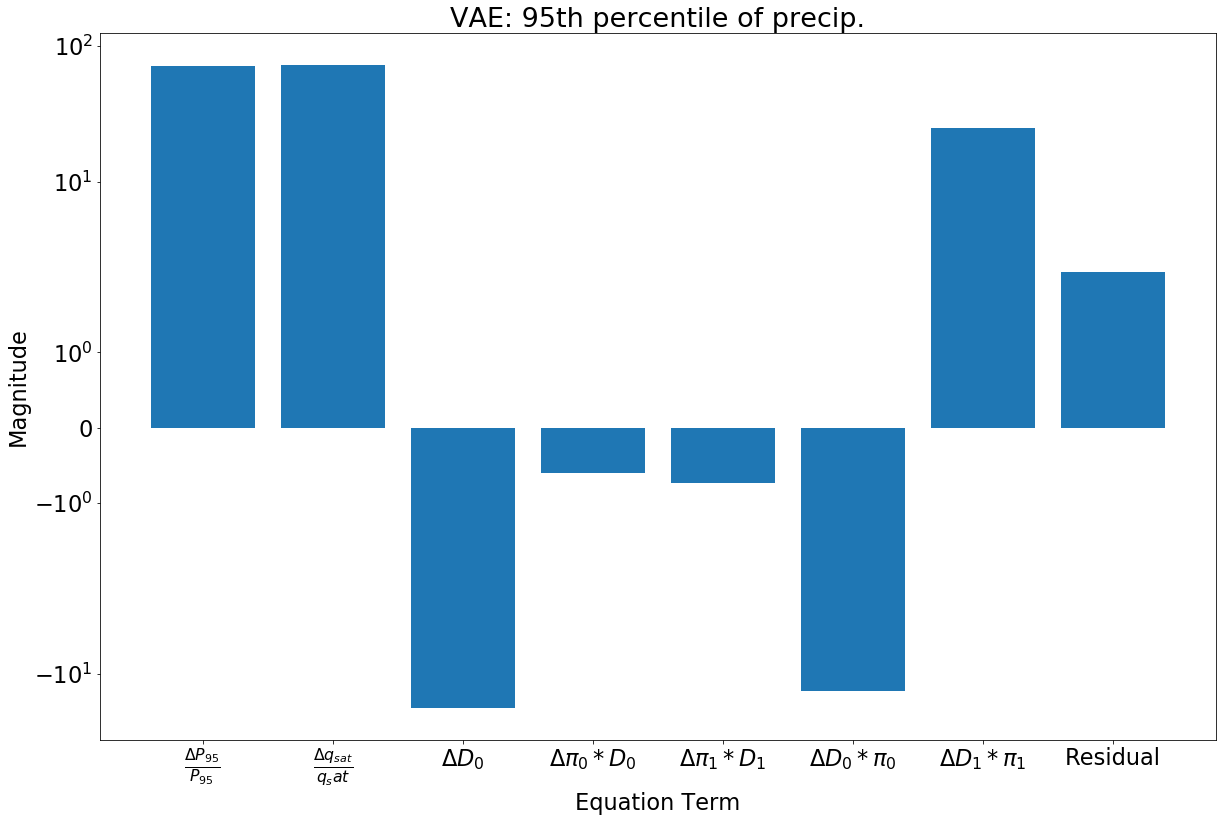

In [31]:
fig, ax = plt.subplots(figsize=(20, 13))

ax.bar(names, values)

ax.set_xlabel("Equation Term")
ax.set_ylabel("Magnitude")
ax.set_title("VAE: 95th percentile of precip.")
ax.set_yscale('symlog')

In [32]:
values = [np.ma.masked_invalid(delta_p_extreme_over_p_extreme*P_95_4k).mean(), (delta_q_sat_over_q_sat*P_95_4k).mean(), (delta_d_0*P_95_4k).mean(), 
          (delta_pi_one_times_d_one*P_95_4k).mean(), (delta_pi_two_times_d_two*P_95_4k).mean(), 
          (pi_one_times_delta_d_one*P_95_4k).mean(), (pi_two_times_delta_d_two*P_95_4k).mean(), np.ma.masked_invalid(residual*P_95_4k).mean()]

names = [r'$\Delta P_{95}}$', r'$\frac{\Delta q_{sat}}{q_sat}*P_{95}$', r'$\Delta D_0 P_{95}$', 
         r'$\Delta \pi_0 * D_0 P_{95}$', r'$\Delta \pi_1 * D_1 P_{95}$',
        r'$\Delta D_0 * \pi_0 P_{95}$', r'$\Delta D_1 * \pi_1 P_{95}$', r'$Residual P_{95}$']

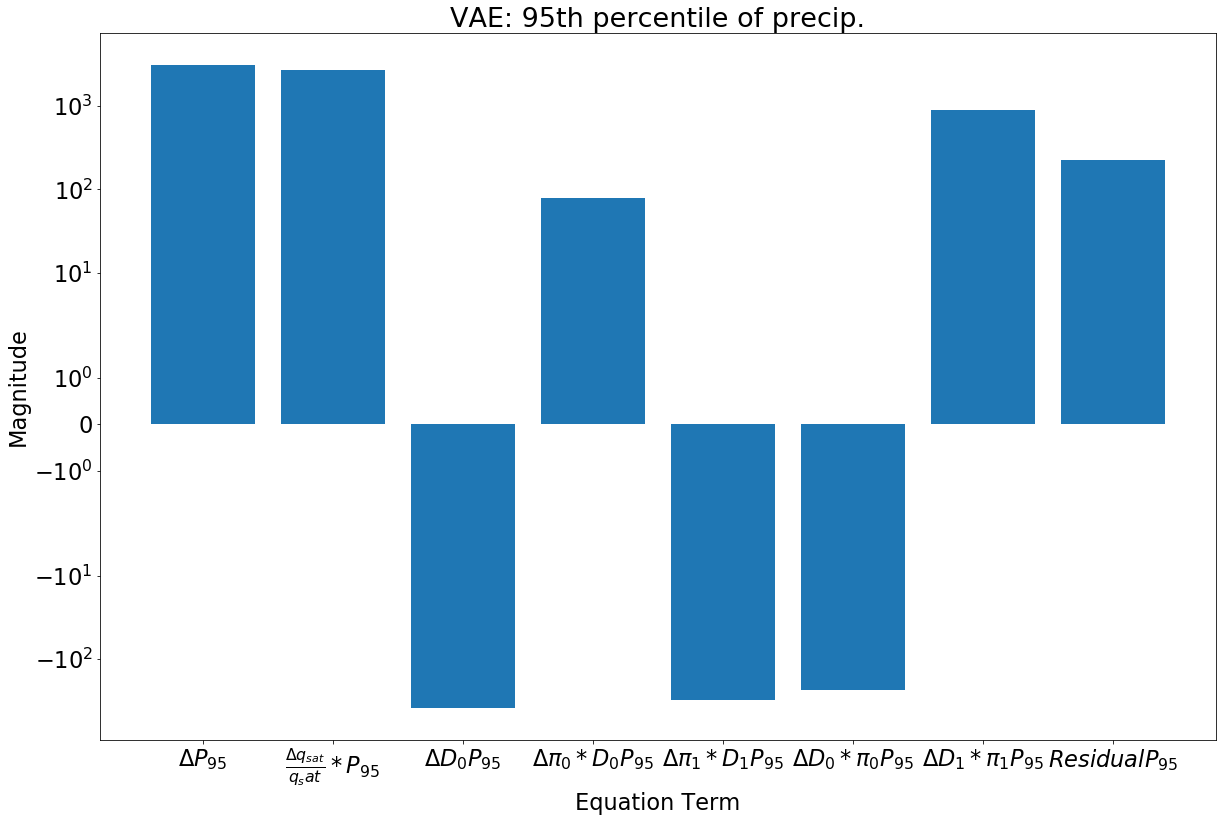

In [33]:
fig, ax = plt.subplots(figsize=(20, 13))

ax.bar(names, values)

ax.set_xlabel("Equation Term")
ax.set_ylabel("Magnitude")
ax.set_title("VAE: 95th percentile of precip.")
ax.set_yscale('symlog')

In [34]:
values = [np.ma.masked_invalid(delta_p_extreme_over_p_extreme*P_95_4k).mean(), 
          (delta_q_sat_over_q_sat*P_95_4k).mean(), 
          (delta_d_0*P_95_4k).mean(), 
          (delta_pi_one_times_d_one*P_95_4k).mean() +(delta_pi_two_times_d_two*P_95_4k).mean(), 
          (pi_one_times_delta_d_one*P_95_4k).mean() +(pi_two_times_delta_d_two*P_95_4k).mean(),
          np.ma.masked_invalid(residual*P_95_4k).mean()]

names = [r'$\Delta P_{95}}$', r'$\frac{\Delta q_{sat}}{q_sat}*P_{95}$', r'$\Delta D_0 P_{95}$', 
         r'$\Delta \pi \ Term$', 
        r'$\Delta D\ Term$', r'$Residual P_{95}$']

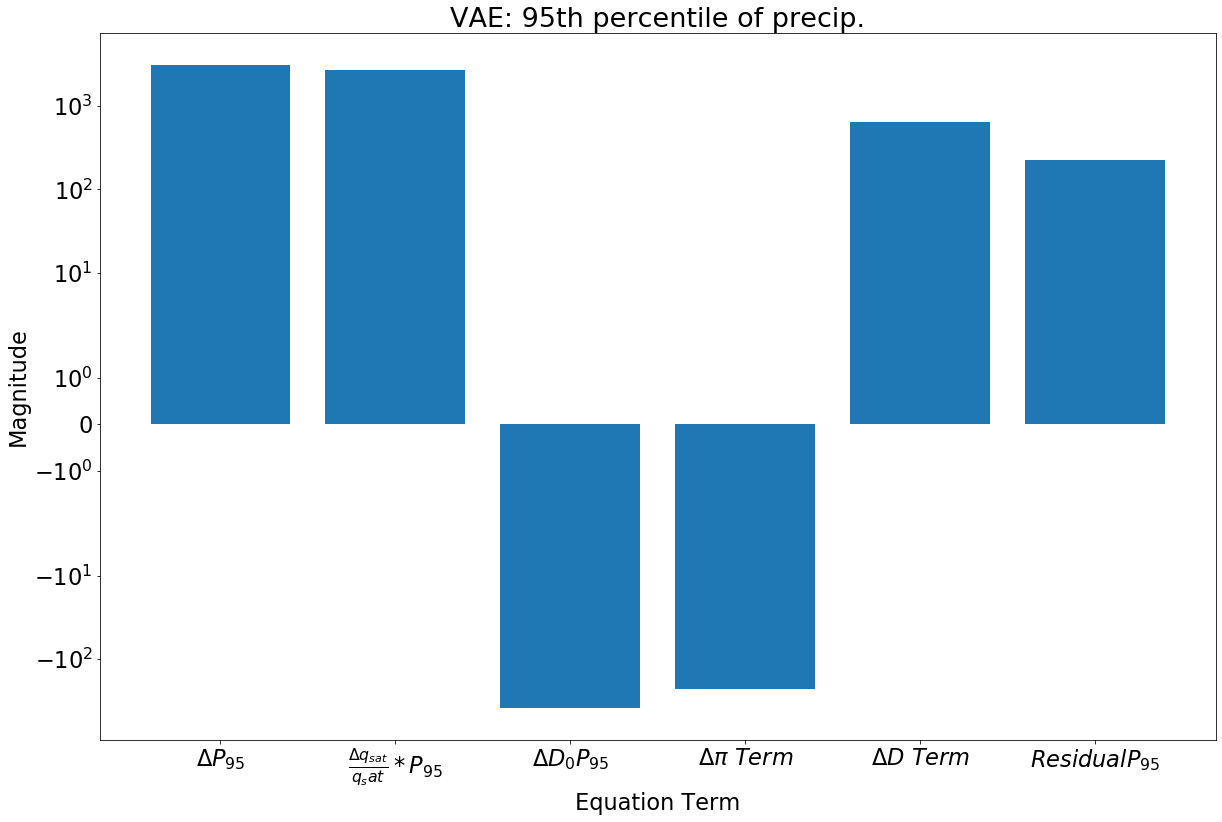

In [35]:
fig, ax = plt.subplots(figsize=(20, 13))

ax.bar(names, values)

ax.set_xlabel("Equation Term")
ax.set_ylabel("Magnitude")
ax.set_title("VAE: 95th percentile of precip.")
ax.set_yscale('symlog')

In [36]:
values = [np.ma.masked_invalid((delta_p_extreme_over_p_extreme*P_95_4k) - np.ma.masked_invalid(delta_p_extreme_over_p_extreme*P_95_4k).mean()).mean(), 
          (delta_q_sat_over_q_sat*P_95_4k - (delta_q_sat_over_q_sat*P_95_4k).mean()).mean(), 
          (delta_d_0*P_95_4k - (delta_d_0*P_95_4k).mean()).mean(), 
          ((delta_pi_one_times_d_one*P_95_4k +delta_pi_two_times_d_two*P_95_4k) - (delta_pi_one_times_d_one*P_95_4k +delta_pi_two_times_d_two*P_95_4k).mean()).mean(), 
          ((pi_one_times_delta_d_one*P_95_4k + pi_two_times_delta_d_two*P_95_4k)-(pi_one_times_delta_d_one*P_95_4k + pi_two_times_delta_d_two*P_95_4k).mean()).mean(),
          np.ma.masked_invalid((residual*P_95_4k) - np.ma.masked_invalid(residual*P_95_4k).mean()).mean()]

names = [r'$\Delta P_{95}}$', r'$\frac{\Delta q_{sat}}{q_sat}*P_{95}$', r'$\Delta D_0 P_{95}$', 
         r'$\Delta \pi \ Term$', 
        r'$\Delta D\ Term$', r'$Residual P_{95}$']

Text(0.5, 1.0, 'VAE: 95th percentile of precip.')

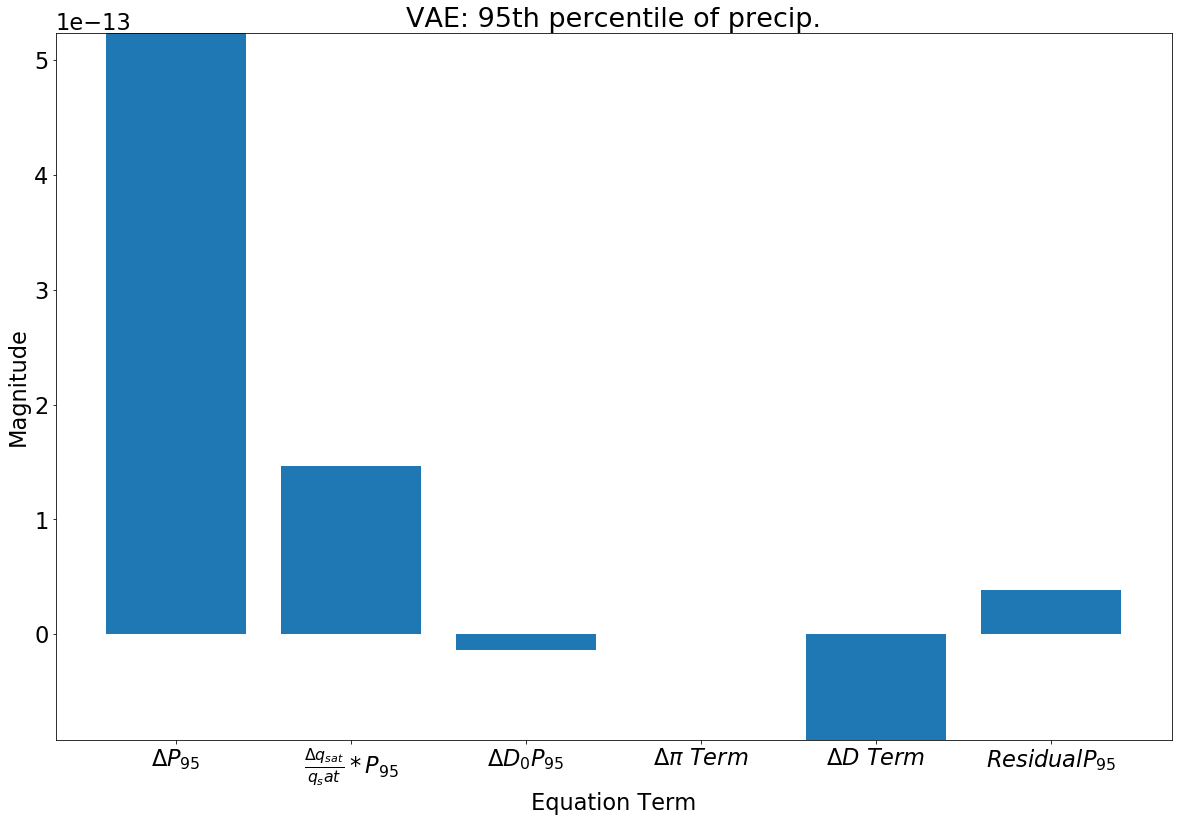

In [37]:
fig, ax = plt.subplots(figsize=(20, 13))

ax.bar(names, values)

ax.set_xlabel("Equation Term")
ax.set_ylabel("Magnitude")
ax.set_title("VAE: 95th percentile of precip.")

In [38]:
p_term = (delta_p_extreme_over_p_extreme*P_95_4k) - np.ma.masked_invalid(delta_p_extreme_over_p_extreme*P_95_4k).mean()
q_term = delta_q_sat_over_q_sat*P_95_4k - (delta_q_sat_over_q_sat*P_95_4k).mean()
D_0_term = delta_d_0*P_95_4k - (delta_d_0*P_95_4k).mean()
delta_pi_term = (delta_pi_one_times_d_one*P_95_4k + delta_pi_two_times_d_two*P_95_4k) - (delta_pi_one_times_d_one*P_95_4k +delta_pi_two_times_d_two*P_95_4k).mean()
delta_d_term = (pi_one_times_delta_d_one*P_95_4k + pi_two_times_delta_d_two*P_95_4k)-(pi_one_times_delta_d_one*P_95_4k + pi_two_times_delta_d_two*P_95_4k).mean()
rough_residual = (residual*P_95_4k) - np.ma.masked_invalid(residual*P_95_4k).mean()


Text(0.5, 1.0, '$\\Delta P^{\\prime}_{95}$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


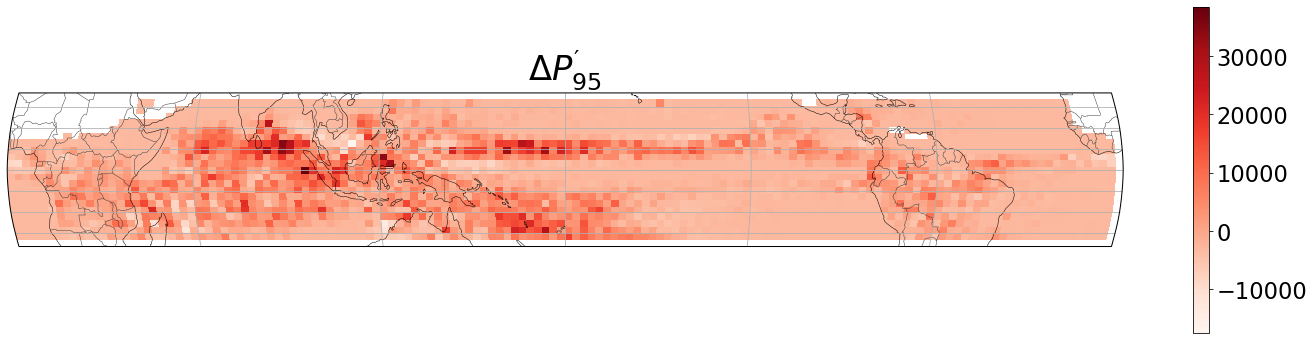

In [39]:
fig, ax = plt.subplots(figsize=(25,6),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})


contour_plot = ax.pcolormesh(new_lons, new_lats, p_term, cmap="Reds", transform=ccrs.PlateCarree())#, vmin=vmin, vmax = vmax, rasterized=True)
plt.colorbar(contour_plot, ax=ax)
ax.coastlines(linewidth=0.5,edgecolor='0.25') 
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.set_title(r"$\Delta P^{\prime}_{95}$", fontsize = 1.5*fz)

Text(0.5, 1.0, '$Q^{\\prime}$')

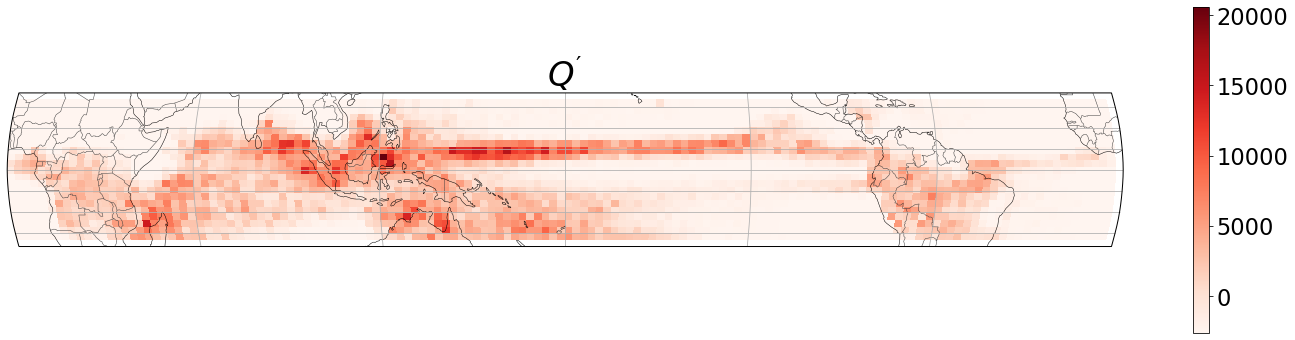

In [40]:
fig, ax = plt.subplots(figsize=(25,6),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})


contour_plot = ax.pcolormesh(new_lons, new_lats, q_term, cmap="Reds", transform=ccrs.PlateCarree())#, vmin=vmin, vmax = vmax, rasterized=True)
plt.colorbar(contour_plot, ax=ax)
ax.coastlines(linewidth=0.5,edgecolor='0.25') 
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.set_title(r"$Q^{\prime}$", fontsize = 1.5*fz)

Text(0.5, 1.0, '$(D_0 * P_{95})^{\\prime}$')

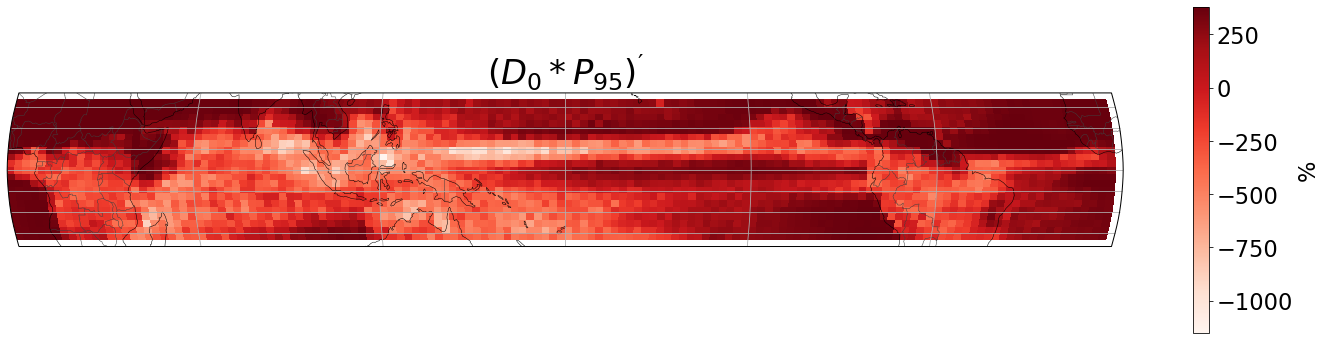

In [41]:
fig, ax = plt.subplots(figsize=(25,6),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})


contour_plot = ax.pcolormesh(new_lons, new_lats, D_0_term, cmap="Reds", transform=ccrs.PlateCarree())#, vmin=vmin, vmax = vmax, rasterized=True)
plt.colorbar(contour_plot, ax=ax, label="%")
ax.coastlines(linewidth=0.5,edgecolor='0.25') 
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.set_title(r"$(D_0 * P_{95})^{\prime}$", fontsize = 1.5*fz)

Text(0.5, 1.0, '$(\\Delta \\pi)^{\\prime} \\ term$')

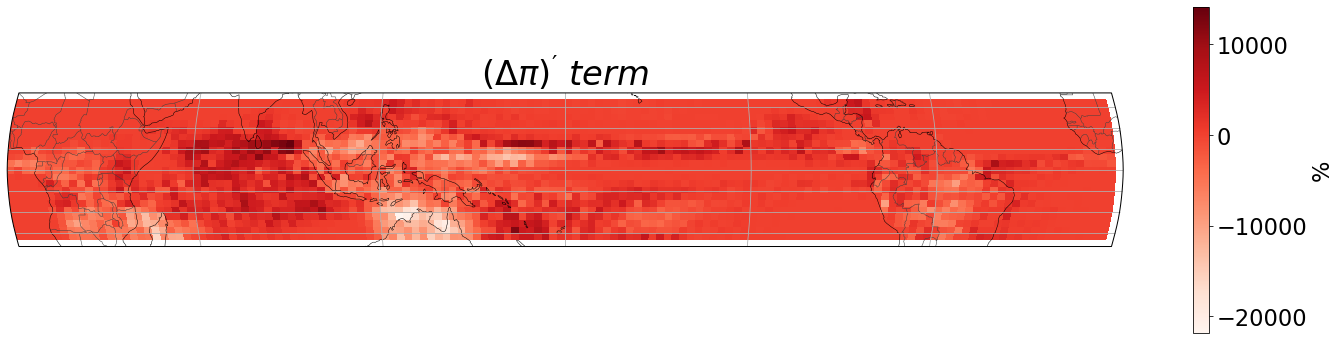

In [42]:
fig, ax = plt.subplots(figsize=(25,6),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})


contour_plot = ax.pcolormesh(new_lons, new_lats, delta_pi_term, cmap="Reds", transform=ccrs.PlateCarree())#, vmin=vmin, vmax = vmax, rasterized=True)
plt.colorbar(contour_plot, ax=ax, label="%")
ax.coastlines(linewidth=0.5,edgecolor='0.25') 
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.set_title(r"$(\Delta \pi)^{\prime} \ term$", fontsize = 1.5*fz)

Text(0.5, 1.0, '$(\\Delta D)^{\\prime} \\ term$')

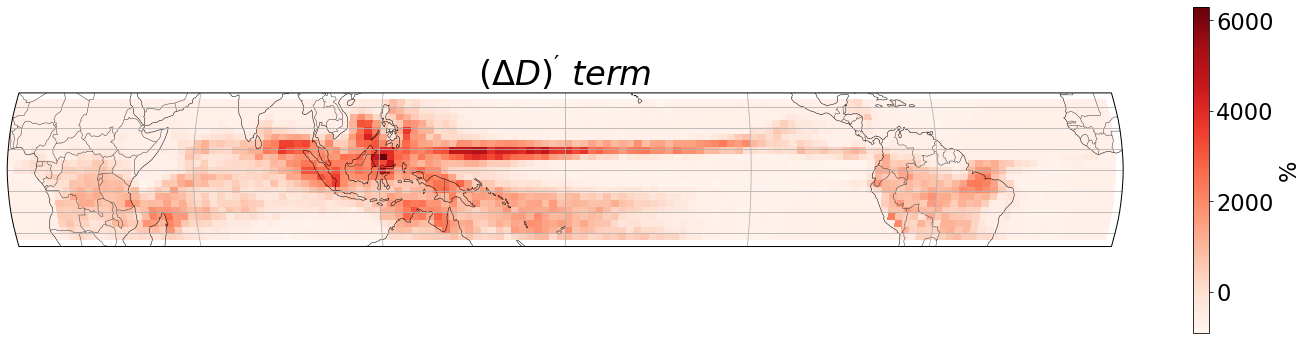

In [43]:
fig, ax = plt.subplots(figsize=(25,6),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})


contour_plot = ax.pcolormesh(new_lons, new_lats, delta_d_term, cmap="Reds", transform=ccrs.PlateCarree())#, vmin=vmin, vmax = vmax, rasterized=True)
plt.colorbar(contour_plot, ax=ax, label="%")
ax.coastlines(linewidth=0.5,edgecolor='0.25') 
ax.gridlines()
ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax.set_title(r"$(\Delta D)^{\prime} \ term$", fontsize = 1.5*fz)

In [44]:
p_squared = p_term**2
a_squared = q_term**2
b_squared = delta_pi_term**2
c_squared = delta_d_term**2
two_a_b = 2*q_term*delta_pi_term
two_a_c = 2*q_term*delta_d_term
two_b_c = 2*delta_pi_term*delta_d_term

residual = p_squared - (a_squared+b_squared+c_squared+two_a_b+two_a_c+two_b_c)

In [45]:
values = [np.ma.masked_invalid(p_squared).mean(), 
          (a_squared).mean(), 
          (b_squared).mean(), 
          (c_squared).mean(), 
          (two_a_b).mean(),
          (two_a_c).mean(),
         (two_b_c).mean(),
         np.ma.masked_invalid(residual).mean(),]


names = [r'$\Delta P_{95}^{\prime}}$', r'$a^2$', r'$b^2$', 
         r'$c^2$', 
        r'$2ab$', r'$2ac$', r'$2bc$', 'residual']

Text(0.5, 1.0, 'VAE: 95th percentile of precip.')

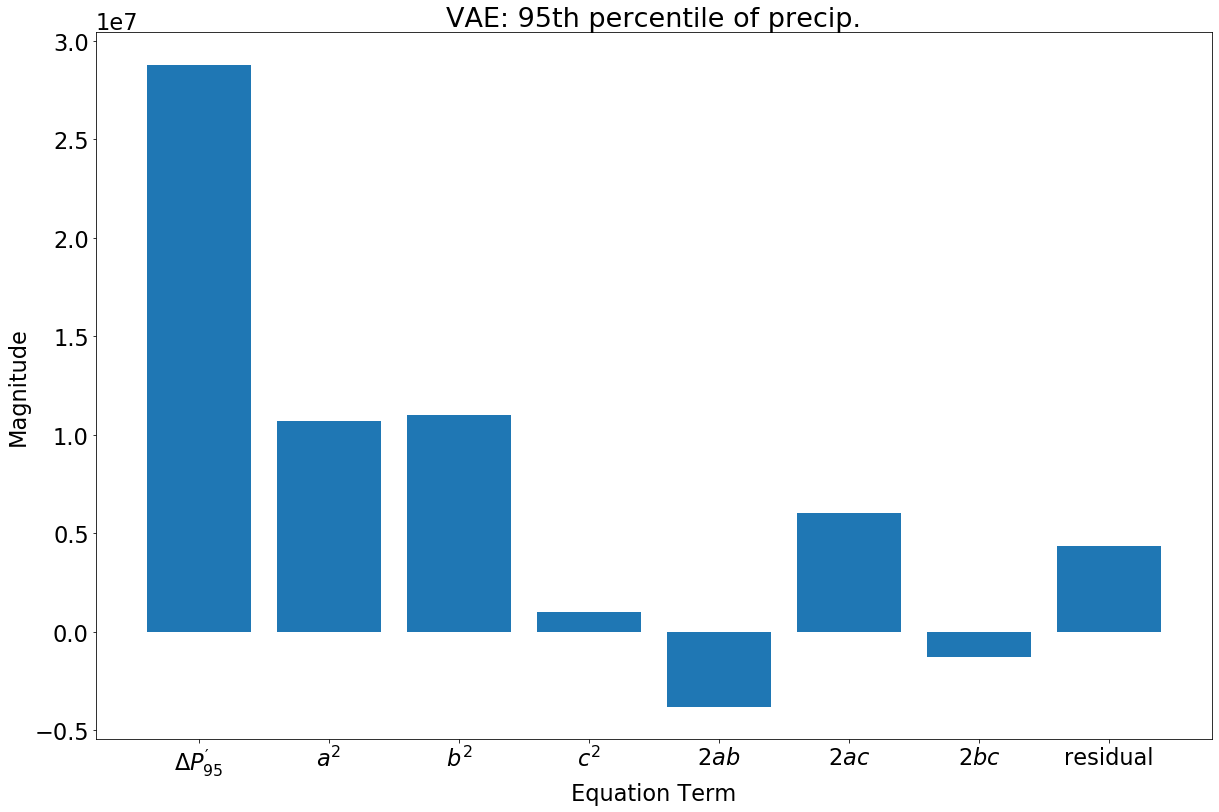

In [46]:
fig, ax = plt.subplots(figsize=(20, 13))

ax.bar(names, values)

ax.set_xlabel("Equation Term")
ax.set_ylabel("Magnitude")
ax.set_title("VAE: 95th percentile of precip.")

# New Part

## Get the terms

In [78]:
Var_Pe = np.nanvar(delta_p_extreme_over_p_extreme*P_95_4k)
Var_Q = np.var(q_term)
delta_D_0_var_qsat = (delta_d_0 ** 2) * (np.var(qsat_4K))
new_delta_pi_term = np.var(qsat_4K * (delta_pi_one_times_d_one + delta_pi_two_times_d_two))
new_delta_d_term = np.var(qsat_4K * (pi_one_times_delta_d_one + pi_two_times_delta_d_two))            

### cross terms

In [79]:
q_prime = q_term - q_term.mean()
q_sat_prime = qsat_4K - qsat_4K.mean()
part_b = (q_prime + delta_d_0*q_sat_prime)

something_prime_delta_pi = (qsat_4K * (delta_pi_one_times_d_one + delta_pi_two_times_d_two)) - (qsat_4K * (delta_pi_one_times_d_one + delta_pi_two_times_d_two)).mean()
something_prime_delta_D = (qsat_4K * (pi_one_times_delta_d_one + pi_two_times_delta_d_two)) - (qsat_4K * (pi_one_times_delta_d_one + pi_two_times_delta_d_two)).mean()


ct_delta_pi_term = (2.0*something_prime_delta_pi*part_b).mean()
ct_delta_D_term = (2.0*something_prime_delta_D*part_b).mean()

term_a = 2.0*delta_d_0*q_sat_prime*q_prime
ct_other = (term_a+(2*something_prime_delta_pi*something_prime_delta_D)).mean()

### residuals

In [80]:
Numerical_Residual = (Var_Pe) - (Var_Q+delta_D_0_var_qsat+new_delta_pi_term+new_delta_d_term+ct_delta_pi_term+ct_delta_D_term+ct_other)
Total_Residual = Numerical_Residual + ct_other

## list and plot

In [98]:
values = [Var_Pe, 
          Var_Q, 
          delta_D_0_var_qsat, 
          new_delta_pi_term, 
          new_delta_d_term,
          ct_delta_pi_term,
         ct_delta_D_term,
        Total_Residual,
           ]


names = [r'$Var(\Delta P_{e})$', 
         r'$Var(Q)$', 
         r'$\Delta D_{0}^2*var(q_{sat})$', 
         r'$var(q_{sat} \sum_{i=1}^N \Delta \ pi_i D_i)$', 
        r'$var(q_{sat} \sum_{i=1}^N \Delta D_i \pi_i)$',
         r'$\overline{(CT)_{\Delta \pi}}$', 
         r'$\overline{(CT)_{\Delta D}}$', 
         r'$\overline{Total \ Residual}$',
        ]

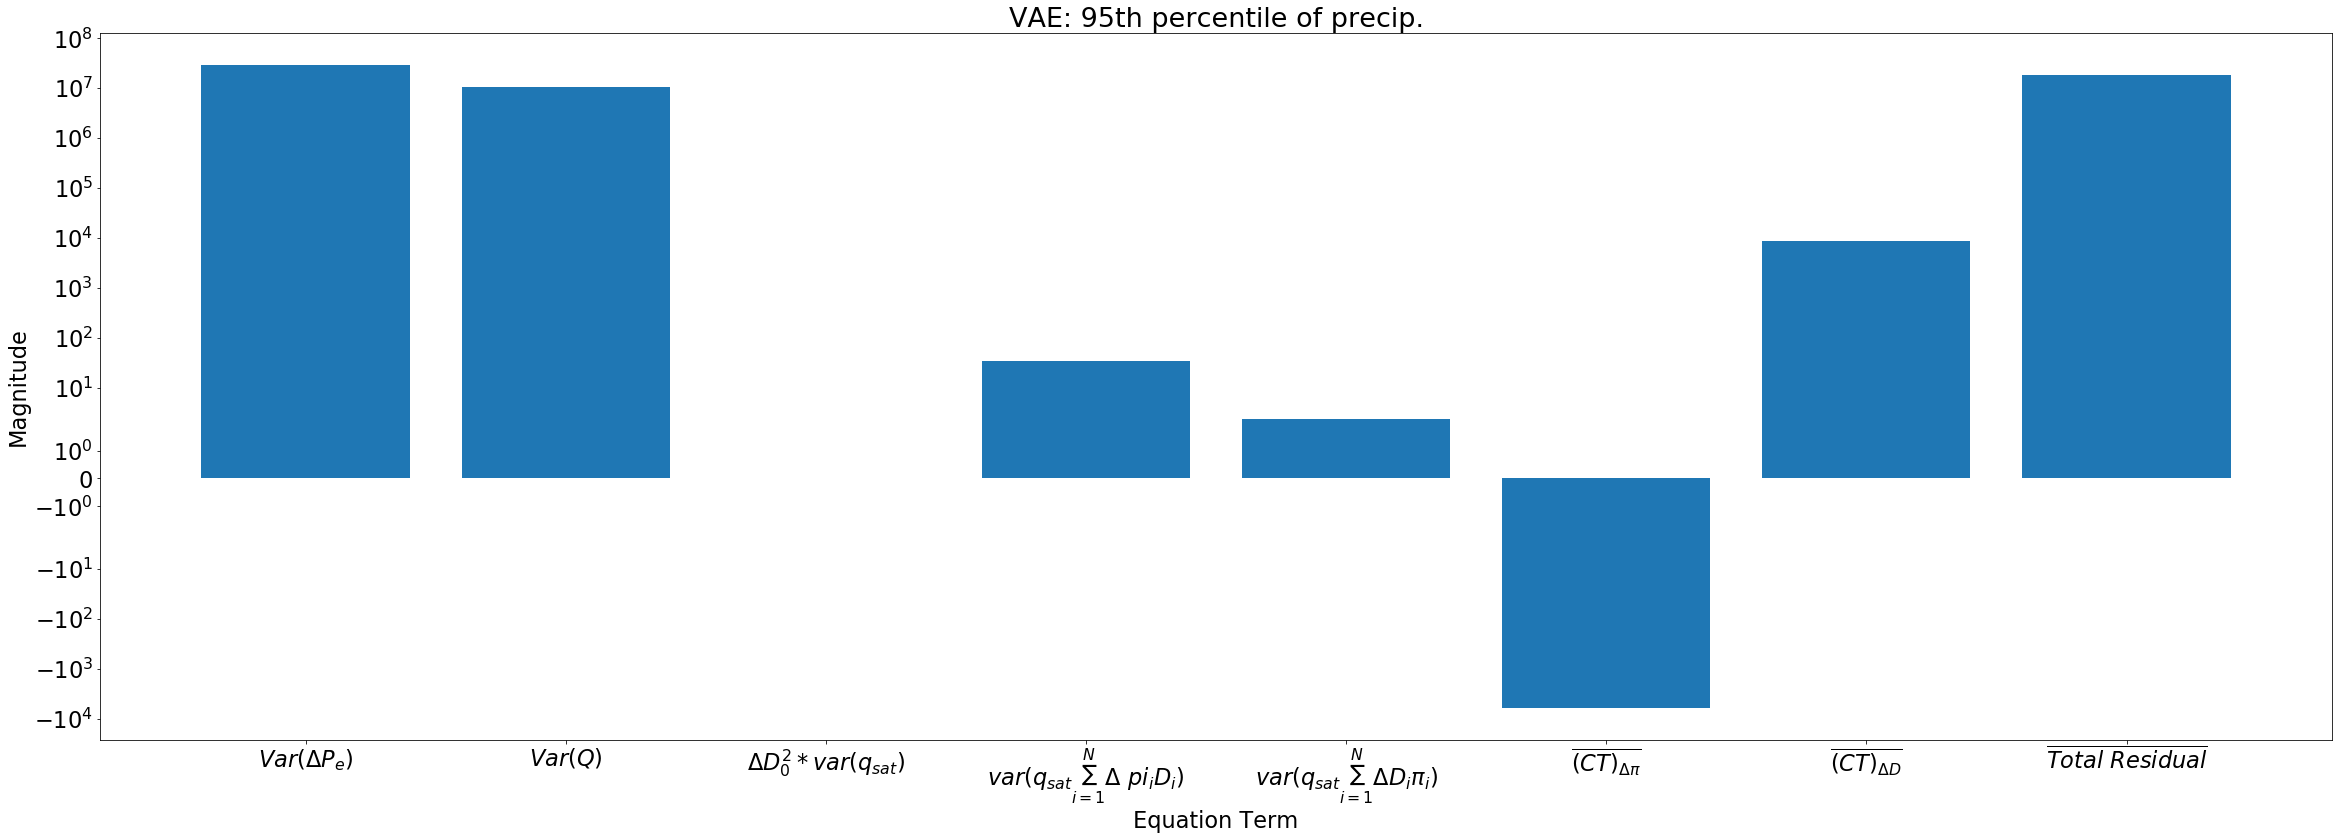

In [103]:
fig, ax = plt.subplots(figsize=(40, 13))

ax.bar(names, values)

ax.set_xlabel("Equation Term")
ax.set_ylabel("Magnitude")
ax.set_title("VAE: 95th percentile of precip.")
ax.set_yscale('symlog')